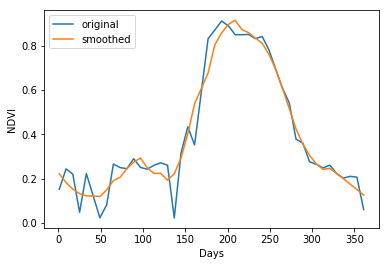

In [3]:
#    $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$//
#                               Main Program
#          This program is used to extract the Phenology data using MODIS
#    $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$//

# Import GEE, other Libraries, and self-defined functions
import ee
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import functions as fs
ee.Initialize()

# Import MODIS and Climate Date and test point
modis = ee.ImageCollection('MODIS/006/MOD09Q1')
climate = ee.ImageCollection('NASA/ORNL/DAYMET_V3')
point = ee.Geometry.Point(-96.47590559683476, 41.16610432898533)

# Filter data using year and point
modisf = ee.ImageCollection(modis.filterDate('2001-01-01', '2001-12-31').filterBounds(point))
climatef = ee.ImageCollection(climate.filterDate('2001-01-01', '2001-12-31').filterBounds(point))

# Calculate NDVI from MODIS and generate time series NDVI within one year
modisndvi = modisf.map(fs.AddNdvi)
ndvi = modisndvi.select('ndvi').getRegion(geometry=point, scale=30)
header = ee.List(ndvi).getInfo()[0]
ndvilist = pd.DataFrame(ee.List(ndvi).getInfo()[1:], columns=header)
ndvilist['datetime'] = pd.to_datetime(ndvilist['time'], unit='ms')
ndvilist.set_index('time')
ndvilist = ndvilist.sort_values('datetime')
ndvitime = ndvilist['datetime'].tolist()
ndviday = fs.dayyear(ndvitime)
ndvivalue = ndvilist['ndvi'].tolist()

# Perform null and negative values, refer to the functions.py file for the removenn function
mndvi = fs.removenn(ndvivalue)

# perform the savitzky-gloay-smoothing for NDVI data and visulize the result
sndvi = scipy.signal.savgol_filter(mndvi, 11, 2)

plt.plot(ndviday ,mndvi)
plt.plot(ndviday ,sndvi)
plt.xlabel('Days')
plt.ylabel('NDVI')
plt.legend(['original','smoothed'],loc='upper left')
plt.show()

a


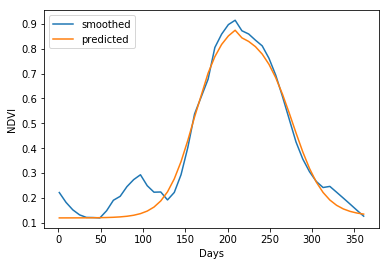

In [4]:
# Calcaulte the crop intensity, maxNDVI, maxNDVI day etc.
intensity, maxv, maxindex, minv, minindex = fs.intense(sndvi)

# Prepare training data for logistic regression anlysis, only one season was adopted in this case
ndvidate1 = np.array(ndviday[:maxindex[0]+1])
ndvidate2 = np.array(ndviday[maxindex[0]+1:])
ndvidata1 = np.array(fs.predata(sndvi[:maxindex[0]+1]))
ndvidata2 = np.array(fs.predata(sndvi[maxindex[0]+1:]))

min1=min(sndvi[:maxindex[0]+1])
min2=min(sndvi[maxindex[0]+1:])
max1=max(sndvi[:maxindex[0]+1])
max2=max(sndvi[maxindex[0]+1:])
popt1,pcov1=fs.curvefit(ndvidate1,ndvidata1)
popt2, pcov2 = fs.curvefit(ndvidate2, ndvidata2)

# Use fitted model to simulate NDVI value and visulize
pred1=fs.validate(ndvidate1,min1,max1,popt1)
pred2=fs.validate(ndvidate2,min2,max2,popt2)
pred=pred1+pred2
plt.plot(ndviday ,sndvi)
plt.plot(ndviday ,pred)
plt.xlabel('Days')
plt.ylabel('NDVI')
plt.legend(['smoothed','predicted'],loc='upper left')
plt.show()

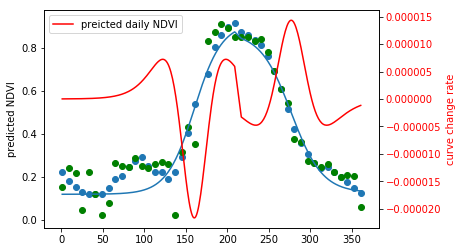

Greenday:122; Matureday:198; Senesday:234; Dormanday:320


In [21]:
# Use the logistic model to calculate the rate of curvation change to derive the four phenology dates
predicted1,curvate1,greenday,matureday,allday1=fs.curverate(ndvidate1,min1,max1,popt1)
predicted2,curvate2,senesday,dormanday,allday2=fs.curverate(ndvidate2,min2,max2,popt2)
predicted=predicted1+predicted2
curverate=curvate1+curvate2
day=list(allday1)+list(allday2)
fourday=[greenday,matureday,senesday,dormanday]
fourday
# visulize the predicted NDVI, curve rate, and four days
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(ndviday,sndvi)
ax1.scatter(ndviday,mndvi,color ='green' )
ax1.plot(day, predicted)
ax1.set_ylabel('predicted NDVI')
ax2 = ax1.twinx()
ax2.plot(day, curverate, 'r-')
ax2.set_ylabel('curve change rate', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.legend(['preicted daily NDVI','curve change rate'],loc='upper left')
plt.show()
print('Greenday:%i; Matureday:%i; Senesday:%i; Dormanday:%i' %(greenday,matureday,senesday,dormanday))

# Calculate the GDD based on:
![title](GDD.jpg)

Tasseling:122; Matureday:198; Senesday:234; Dormanday:320


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in arcsin
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in arcsin


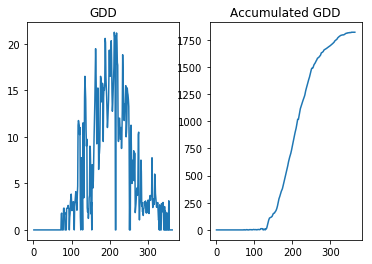

In [91]:
# Process temperature date to calculate daily GDD
tmax = climatef.select('tmax').getRegion(geometry=point, scale=30)
tmin = climatef.select('tmin').getRegion(geometry=point, scale=30)
header = ee.List(tmax).getInfo()[0]
tmaxlist = pd.DataFrame(ee.List(tmax).getInfo()[1:], columns=header)
header = ee.List(tmin).getInfo()[0]
tminlist = pd.DataFrame(ee.List(tmin).getInfo()[1:], columns=header)
tmaxlist['datetime']= pd.to_datetime(tmaxlist['time'], unit='ms')
tminlist['datetime']= pd.to_datetime(tminlist['time'], unit='ms')
tmaxlist.set_index('time')
tmaxlist=tmaxlist.sort_values('datetime')
tminlist=tminlist.sort_values('datetime')
tmaxtime=tmaxlist['datetime'].tolist()
tempday=fs.dayyear(tmaxtime)
tempmax=np.array(tmaxlist['tmax'].tolist())
tempmin=np.array(tminlist['tmin'].tolist())
tempmean=(tempmax+tempmin)/2
alpha=(tempmax-tempmin)/2
phi=3.1415926
angle1=np.arcsin((10-tempmean)/alpha)
angle2=np.arcsin((34-tempmean)/alpha)
gdd=[0]*len(tempmin)

for i in range(len(tempmin)):
    if tempmax[i] < 10:
        gdd[i]=0
    elif tempmax[i] < 34 and tempmin[i] < 10:
        gdd[i]=(1/phi)*((tempmean[i]-10)*(1/phi-angle1[i])+alpha[i]*np.cos(angle1[i]))
    elif tempmax[i] < 34 and tempmin[i] > 10:
        gdd[i]=tempmean[i]-10
    elif tempmax[i] > 34 and tempmin[i] > 10:
        gdd[i]=(1/phi)*((tempmean[i]-10)*(angle2[i]+phi/2)+24*(phi/2-angle2[i])-np.cos(angle2[i]))
    elif tempmax[i] > 34 and tempmin[i] < 10:
        gdd[i]=(1/phi)*((tempmean[i]-10)*(angle2[i]-angle1[i])+alpha[i]*(np.cos(angle1[i])-np.cost(angle2[i]))+24*(phi/2-angle2[i]))
    elif tempmin[i] > 34:
        gdd[i]=24

# Calculate accumulated GDD
ogdd=gdd[:]
agdd=gdd
for i in range(131,364):
    agdd[i]=agdd[i]+gdd[i-1]
    if agdd[i]>=47:
        tasseling=tempday(i)
        print(tasseling)
        gdd[i]=0
    if agdd[i]>=28:
        silking=tempday(i)
        gdd[i]=0
        

        
        
        
        
print('Tasseling:%i; Matureday:%i; Senesday:%i; Dormanday:%i' %(greenday,matureday,senesday,dormanday))        
plt.subplot(1,2,1)
plt.plot(tempday, ogdd)
plt.title('GDD')
plt.subplot(1,2,2)
plt.plot(tempday, agdd)
plt.title('Accumulated GDD')
plt.show()

# GDD needed during Corn Phenology :
![title](pehnology.JPG)

In [92]:
print(ogdd[130:135])
print(gdd[130:135])
print(agdd[130:135])   

[8.75, 3.447409980196721, 7.0, 14.25, 16.5]
[8.75, 12.19740998019672, 19.19740998019672, 33.447409980196724, 49.947409980196724]
[8.75, 12.19740998019672, 19.19740998019672, 33.447409980196724, 49.947409980196724]
